# TERRA Colocolizes to Double Stranded Breaks (DSBs), esp. in G2
This project is the data analysis of Dr. Taghreed Mohammed Al Turki's PhD data, in continuation of Chris Nelson's(?) previous work. The objective is to eelucidate if TERRA locolizes to global DSBs, to telomeric DSB's, and which phase of the cell cycle does TERRA colocolize to telo DSBs. 

In [48]:
# handling data
import pandas as pd
import numpy as np

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value Stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

print("Setup Complete")

Setup Complete


In [49]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


# Setting up the data

We want the data to be read by the program environment so that we can run quick and accurate analysis further on.

In [50]:
### REMEBER TO SAVE AS CSV FOR GITHUB ###

#Data for Global DSB analyis
global_df = pd.read_excel('../Documents/global_DSB_TERRA.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['Distribution of TERRA Foci/Cell', 'Cell Condition']
                              )

global_df.set_index(['Distribution of TERRA Foci/Cell'])
global_df.dropna(axis=0, inplace=True) 

#global_df.columns
global_df.head()

,Distribution of TERRA Foci/Cell,Cell Condition
0,14,2Gy
1,24,2Gy
2,19,2Gy
3,43,2Gy
4,17,2Gy


In [51]:
### REMEBER TO SAVE AS CSV FOR GITHUB ###

#Data for Global DSB analyis
global_pivot_df = pd.read_excel('../Documents/global_DSB_TERRA.xlsx',
                    sheet_name=0,
                    skiprows = 0,
                    #usecols = ['Distribution of TERRA Foci/Cell', 'Cell Condition']
                              )

global_pivot_df.set_index(['2Gy'])
global_pivot_df.dropna(axis=0, inplace=True) 

#global_pivot_df.columns
global_pivot_df.head()

,2Gy,0Gy,2Gy & RNAseA+H,0Gy & RNAseA+H
0,14,2,1.0,8
1,24,2,0.0,5
2,19,1,3.0,5
3,43,0,1.0,8
4,17,11,1.0,6


In [52]:
#Data for telo DSB analyis
telo_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=6,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Colocolization','total_foci','foci_per_cell'
                               
                              ] 
                         )

telo_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
telo_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_df.columns()
telo_df.head()

,Cell_condition,Colocolization,total_foci,foci_per_cell
0,EN-T,FLAG v. TERRA,689.5,25.072727
1,TRF1,FLAG v. TERRA,651.5,21.716667
2,Empty,FLAG v. TERRA,9.5,0.904762
3,Untransfected,FLAG v. TERRA,0.0,0.000000
4,EN-T & RNAseA+H,FLAG v. TERRA,480.5,24.641026


In [53]:
#Data for telo DSB analyis
telo_coloc_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=7,
                    skiprows = 0,
                    usecols = ['Cell Condition', 'FLAG v. TERRA','FLAG v. TRF2 v. TERRA','TRF2 v. TERRA'
                               
                              ] 
                         )

telo_coloc_df.set_index(['Cell Condition'])#good way to fix "not in axis issue"
telo_coloc_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_coloc_df.columns()
telo_coloc_df.head()

,Cell Condition,FLAG v. TERRA,FLAG v. TRF2 v. TERRA,TRF2 v. TERRA
0,EN-T,25.072727,7.436364,0.181818
1,TRF1,21.716667,10.050000,0.616667
2,Empty,0.904762,1.857143,10.476190
3,Untransfected,0.000000,0.000000,0.000000
4,EN-T & RNAseA+H,24.641026,2.923077,0.179487


In [54]:
#Data for telo DSB analyis
telo_cell_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=8,
                    skiprows = 0,
                    usecols = ['Colocolization', 'EN-T','TRF1','Empty','Untransfected','EN-T & RNAseA+H',
                               'TRF1 & RNAseA+H','Empty & RNAseA+H','Untransfected & RNAseA+H'   
                              ] 
                         )

telo_cell_df.set_index(['Colocolization'])#good way to fix "not in axis issue"
telo_cell_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_cell_df.columns()
telo_cell_df.head()

,Colocolization,EN-T,TRF1,Empty,Untransfected,EN-T & RNAseA+H,TRF1 & RNAseA+H,Empty & RNAseA+H,Untransfected & RNAseA+H
0,FLAG v. TERRA,25.072727,21.716667,0.904762,0.000000,24.641026,11.380952,7.500000,0.0
1,FLAG v. TERRA,39.486486,32.428571,13.095238,0.000000,18.000000,29.051724,12.631579,0.0
2,FLAG v. TERRA,36.553191,35.602564,8.697674,0.000000,26.000000,26.741935,20.509091,0.0
3,FLAG v. TERRA,44.680851,42.129870,8.916667,8.666667,30.640000,39.086957,4.642857,0.0
4,FLAG v. TERRA,32.786885,37.803279,7.457143,0.000000,15.264706,18.382979,8.228571,0.0


In [89]:
# To look at the relationship betweeen cell accumulation and TERRA accumulation per phase
g2_df = pd.read_excel('../Documents/telomere_G2_DSB_TERRA.xlsx',
                    sheet_name=6,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Phase','TERRA Amount','Cell_Amount',
                               'TERRA_%_In_Phase','Cell_%_In_Phase'] 
                         )

g2_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
g2_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#g2_df.columns()
g2_df.head(6)

,Cell_condition,Phase,TERRA Amount,TERRA_%_In_Phase,Cell_Amount,Cell_%_In_Phase
0,Empty,G1,132.0,10.806386,9.0,11.920530
1,Empty,G1,346.5,23.467660,16.5,24.812030
2,Empty,G1,814.0,41.267427,50.5,49.029126
3,Empty,G1,437.0,20.349243,21.0,21.761658
4,Empty,G1,264.0,13.618777,16.0,17.391304
5,Empty,S,65.0,5.321326,2.0,2.649007


# TERRA Responds to Global DSBs
   - What the experiment is (e.g. what is it testing and how):
   - "To induce Global DSBs, U2OS cells were treated with 2 gy Gamma rays, recovered for 4 hours, fixed." 
   - "To evaluate the induction of TERRA in response to the Global DSBs, the fixed cells were stained with C-rich labeld PNA probe. The experiment was repeated and cells were treated with a cocktail of  Rnase H and A for the removal of TERRA foci (negative control)." 


## Bar Plot

[None, None, None, None, None, None, None, None]

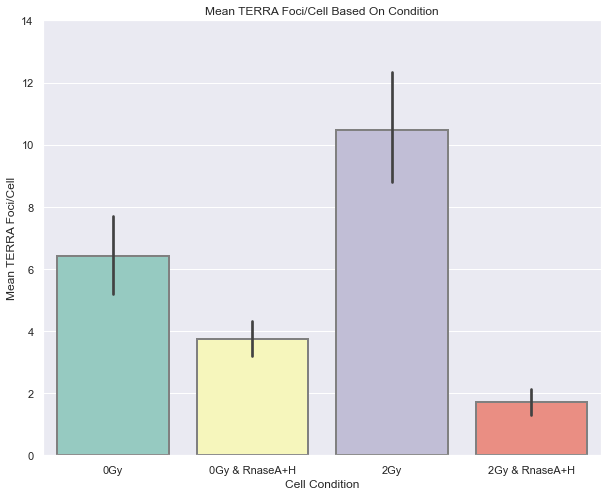

In [56]:
# Bar plot that uses all the values so we can get varience/stats measures
plt.figure(figsize=(10,8))
ax = sns.set(font_scale=1)
ax = sns.barplot(x=global_df['Cell Condition'],y='Distribution of TERRA Foci/Cell',
                 data=global_df,  palette="Set3", order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H'])

ax.set(ylim=(0,14), xlabel='Cell Condition', ylabel = 'Mean TERRA Foci/Cell')
plt.title('Mean TERRA Foci/Cell Based On Condition')
plt.setp(ax.patches, linewidth=2, edgecolor=".5")

## Stats

In [57]:
# one-way ANOVA's 

#Between all the groups
all_global_anova = stats.f_oneway(global_pivot_df['0Gy'],
               global_pivot_df['0Gy & RNAseA+H'],
               global_pivot_df['2Gy'],
               global_pivot_df['2Gy & RNAseA+H'])

#Between 0Gy and 2Gy
Zv2_global_anova = stats.f_oneway(global_pivot_df['0Gy'],
               global_pivot_df['2Gy'],
                )

#Between 0Gy and 0Gy & RNAseA+H
ZvZR_global_anova = stats.f_oneway(global_pivot_df['0Gy'],
               global_pivot_df['0Gy & RNAseA+H'],
               )

#Between 2Gy and 2Gy & RNAseA+H
Gy2v2R_global_anova = stats.f_oneway(global_pivot_df['2Gy'],
               global_pivot_df['2Gy & RNAseA+H'])

print( all_global_anova,'Between All\n',
       Zv2_global_anova,'0Gy vs. 2Gy\n',
       ZvZR_global_anova, '0Gy vs. 0Gy + Rnase\n',
       Gy2v2R_global_anova, '2Gy vs. 2Gy + Rnase\n'
     )

# All p<<0 indicates statistical significant difference between all the groups ****
# 0Gy vs. 2Gy P = 0.00042 indicates difference ***
# 0Gy vs. 0Gy + Rnase P=0.00027 indicates difference ***
# 2Gy vs. 2Gy + Rnase P=<<0 indicates difference ****

F_onewayResult(statistic=40.22130919965053, pvalue=3.673096649706062e-23) Between All
 F_onewayResult(statistic=12.807020720648879, pvalue=0.0004190395594394681) 0Gy vs. 2Gy
 F_onewayResult(statistic=13.687831185821716, pvalue=0.00026860018343309675) 0Gy vs. 0Gy + Rnase
 F_onewayResult(statistic=84.44535425121381, pvalue=2.1100880702536034e-17) 2Gy vs. 2Gy + Rnase



In [58]:
# perform Tukey HSD to confirm ANOVA results
global_tukey = pairwise_tukeyhsd(endog=global_df['Distribution of TERRA Foci/Cell'],
                          groups=global_df['Cell Condition'],
                          alpha=0.05)

print(global_tukey)

#Tukey HSD confirms the differences and includes that the +RNAse groups are not stat. different

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
           0Gy 0Gy & RnaseA+H    -2.65 0.0085  -4.7985 -0.5015   True
           0Gy            2Gy   4.0667  0.001   1.9182  6.2152   True
           0Gy 2Gy & RnaseA+H     -4.7  0.001  -6.8485 -2.5515   True
0Gy & RnaseA+H            2Gy   6.7167  0.001   4.5682  8.8652   True
0Gy & RnaseA+H 2Gy & RnaseA+H    -2.05 0.0678  -4.1985  0.0985  False
           2Gy 2Gy & RnaseA+H  -8.7667  0.001 -10.9152 -6.6182   True
---------------------------------------------------------------------


## Box Plot

Text(0.5, 1.0, 'Distributions of TERRA Foci in U2OS Cells')

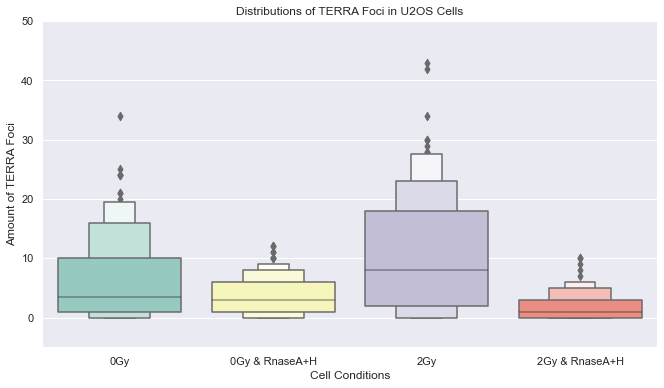

In [59]:
# A better representation of the distribution
f, ax = plt.subplots(figsize=(11, 6))
ax = sns.set(font_scale=1)
ax = sns.boxenplot(x=global_df['Cell Condition'],  palette="Set3", y='Distribution of TERRA Foci/Cell',
                 data=global_df, order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H'])

ax.set(ylim=(-5, 50), xlabel= "Cell Conditions", ylabel="Amount of TERRA Foci")
sns.despine(left=True, bottom=True)
plt.title('Distributions of TERRA Foci in U2OS Cells')

# TERRA Locolizes to Telomeric DSBs
  - What the experiment is (e.g. what is it testing and how):
  - "To measure the colocalization of FLAG and TERRA  RNA FISH and Immunostaining to label FLAG in positively transfected cells and compare it to untransfected population."
  - to test wheather  this system allowed the formation of telomeric DSBs, cells were  fixed and immunostained to detect
    - a.FLAG  ( to label the positvely transfected cells).
    - b. yH2AX ( DSBs marker)
    - c. Edu ( S phase marker) FUCCI marker (G2 marker). 
    - The fixed cells were also stained with G-rich labeld PNA probe  to detect Telomeres (C-rich strands).


## Bar Plots

Text(0.5, 1.0, 'Average Cololocolized Foci Per Cell')

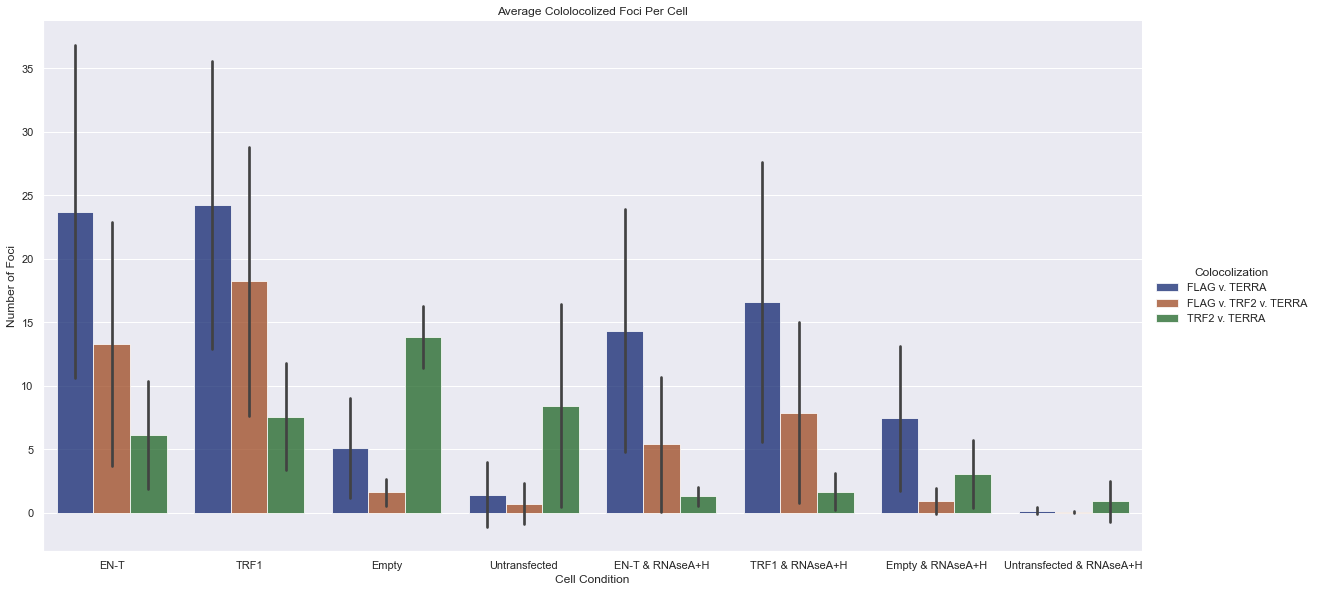

In [60]:
# Catagorical bar plot for
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    ci="sd", palette="dark", alpha=.75, height=8, aspect=2
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
plt.title("Average Cololocolized Foci Per Cell")

Text(0.5, 1.0, 'Average Cololocolized Foci Per Cell')

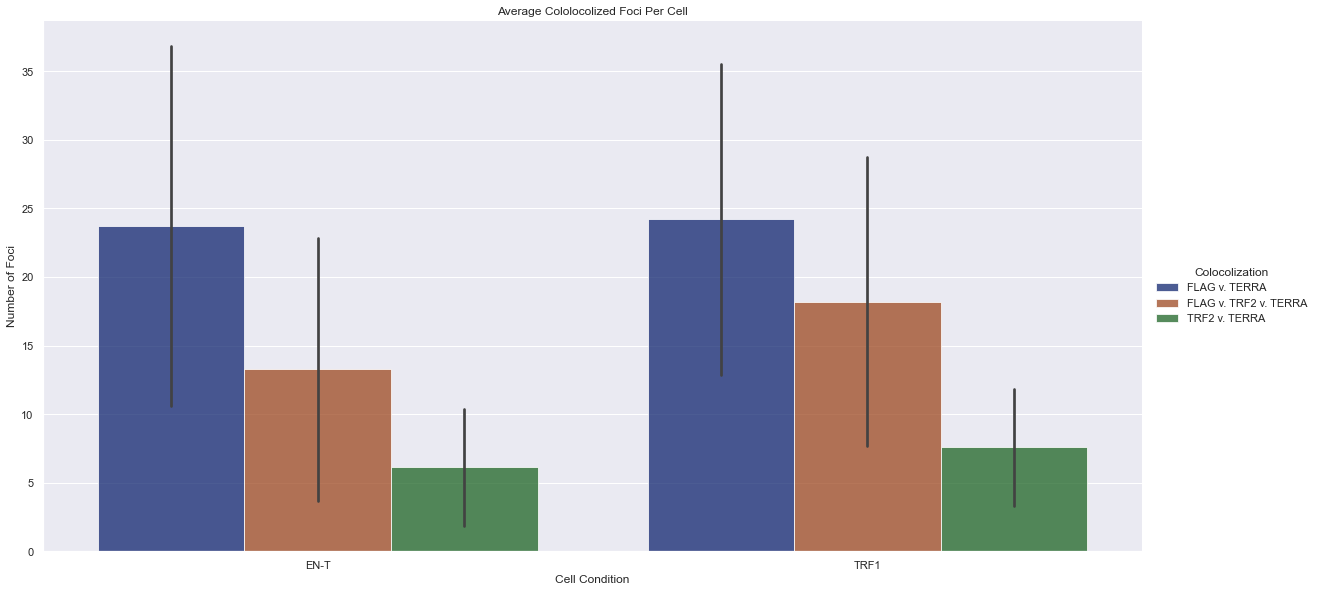

In [61]:
# Show that TERRA responds to DSB's from either EN-T and TRF1
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    ci="sd", palette="dark", alpha=.75, height=8, aspect=2, order=["EN-T","TRF1"]
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
plt.title("Average Cololocolized Foci Per Cell")

In [62]:
a = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['TRF1'].iloc[:10],
                                 )
b =stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['TRF1'].iloc[11:20],
                                 )
c = stats.f_oneway(telo_cell_df['EN-T'].iloc[21:],
               telo_cell_df['TRF1'].iloc[21:],
                                 )
print(a,'Flag\n',b,'tri\n',c,'TRF2\n')

F_onewayResult(statistic=0.0074907920174264305, pvalue=0.9319852347203408) Flag
 F_onewayResult(statistic=1.0146976237782777, pvalue=0.32877203658344184) tri
 F_onewayResult(statistic=0.6622384330590622, pvalue=0.42771618130047206) TRF2



Text(0.5, 1.0, 'Average Cololocolized Foci Per Cell')

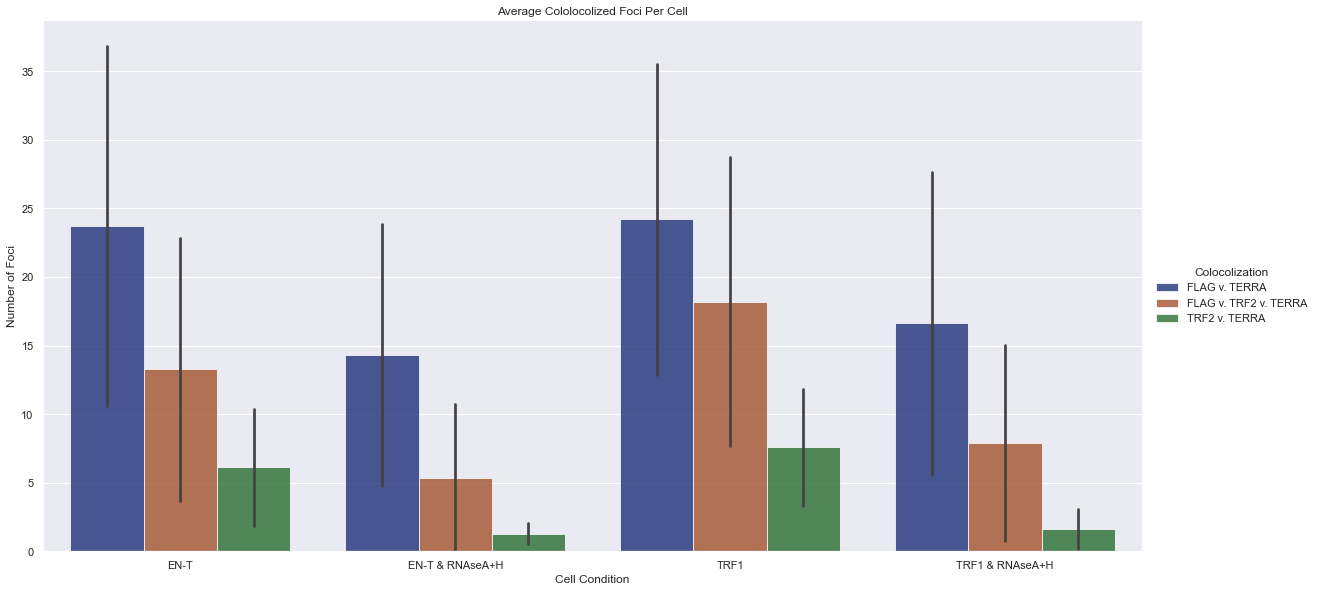

In [63]:
#Show that RNAseA+H reduces levels of TERRA, almost to scale which is intersting
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    ci="sd", palette="dark", alpha=.75, height=8, aspect=2, order=["EN-T","EN-T & RNAseA+H","TRF1","TRF1 & RNAseA+H"]
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
plt.title("Average Cololocolized Foci Per Cell")

In [64]:
d = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['EN-T & RNAseA+H'].iloc[:10],
                                 )

e =stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['EN-T & RNAseA+H'].iloc[11:20],
                                 )

f = stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['EN-T & RNAseA+H'].iloc[11:20],
                                 )

g = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['TRF1 & RNAseA+H'].iloc[:10],
                                 )

h = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['TRF1 & RNAseA+H'].iloc[11:20],
                                 )

i = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['TRF1 & RNAseA+H'].iloc[11:20],
                                 )

print(d,'EN-T Flag\n',e,'EN-T tri\n',f,'EN-T TRF2\n',g,'TRF1 Flag\n',h,'TRF1 tri\n',i,'TRF1  TRF2\n')

F_onewayResult(statistic=2.999429378782151, pvalue=0.10039559636715745) EN-T Flag
 F_onewayResult(statistic=4.231719968983899, pvalue=0.05635779775743202) EN-T tri
 F_onewayResult(statistic=4.231719968983899, pvalue=0.05635779775743202) EN-T TRF2
 F_onewayResult(statistic=2.073295656872315, pvalue=0.16706359345413027) TRF1 Flag
 F_onewayResult(statistic=5.253377629178031, pvalue=0.035802190121200464) TRF1 tri
 F_onewayResult(statistic=5.253377629178031, pvalue=0.035802190121200464) TRF1  TRF2



Text(0.5, 1.0, 'Average Cololocolized Foci Per Cell')

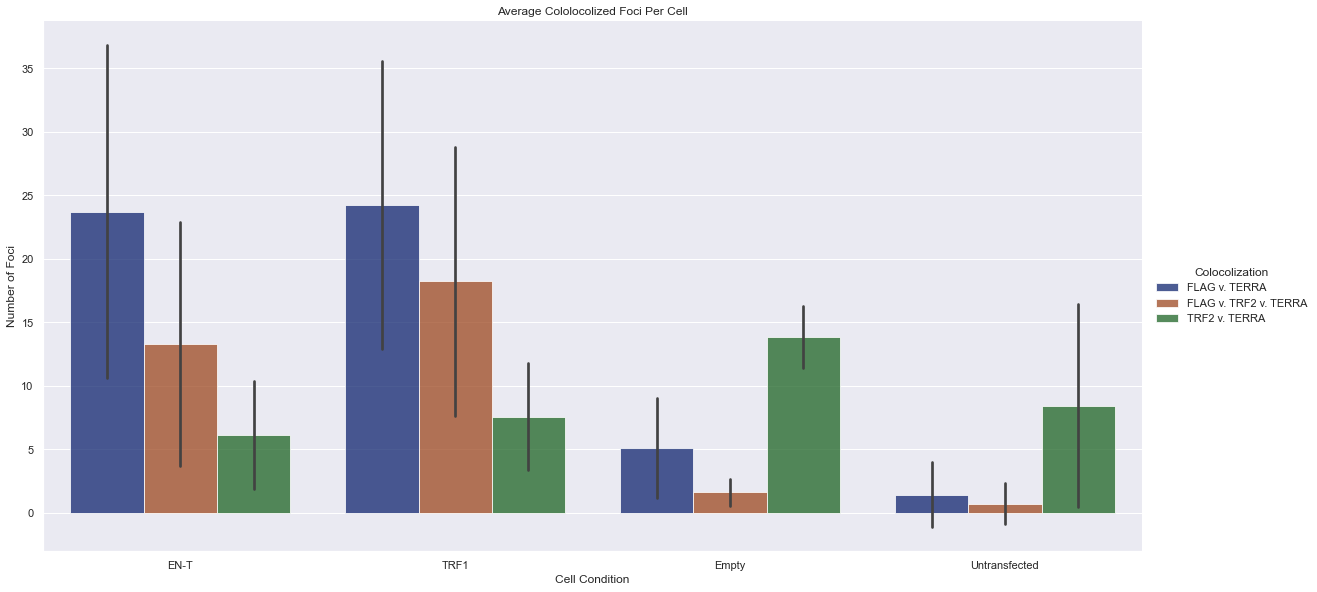

In [65]:
#Show the increased levels of TRF2-TERRA to support that free TERRA is recreuited to telo DSB's
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    ci="sd", palette="dark", alpha=.75, height=8, aspect=2, order=["EN-T","TRF1","Empty","Untransfected"],
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
plt.title("Average Cololocolized Foci Per Cell")

In [66]:
j = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['Empty'].iloc[:10],
                                 )

k =stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )

l = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )

m = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['Untransfected'].iloc[:10],
                                 )

n = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )

o = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )

print(j,'Empty Flag\n',k,'Empty tri\n',l,'Empty TRF2\n',m,'TRF1 Flag\n',n,'Untrans tri\n',o,'Untrans TRF2\n')

F_onewayResult(statistic=22.9040206361094, pvalue=0.00014790840055757597) Empty Flag
 F_onewayResult(statistic=21.048542733031045, pvalue=0.00030324510734208693) Empty tri
 F_onewayResult(statistic=21.048542733031045, pvalue=0.00030324510734208693) Empty TRF2
 F_onewayResult(statistic=34.732299828888685, pvalue=1.4029589978226206e-05) TRF1 Flag
 F_onewayResult(statistic=22.646952255330238, pvalue=0.00021351344139676102) Untrans tri
 F_onewayResult(statistic=22.646952255330238, pvalue=0.00021351344139676102) Untrans TRF2



Text(0.5, 1.0, 'Average Cololocolized Foci Per Cell')

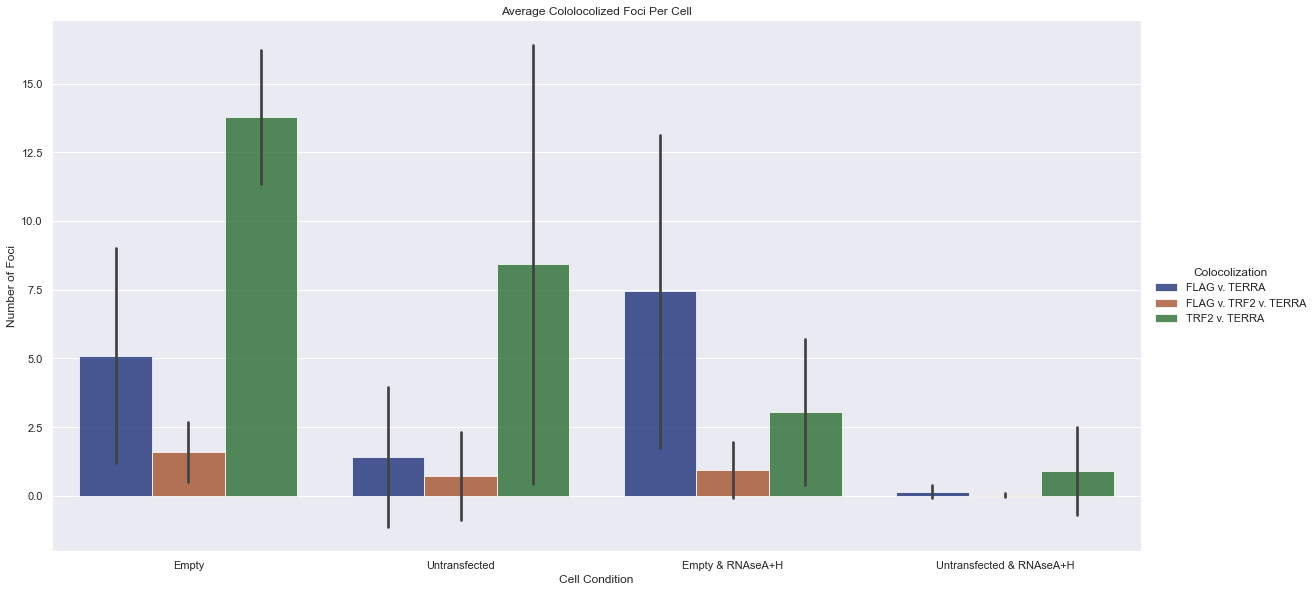

In [67]:
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    ci="sd", palette="dark", alpha=.75, height=8, aspect=2, order=["Empty","Untransfected",
                                                                   "Empty & RNAseA+H","Untransfected & RNAseA+H"],
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
plt.title("Average Cololocolized Foci Per Cell")

## Stats

In [68]:
#Show that across all the cell lines, the amount of terra/cell is different
all_coloc_anova =stats.f_oneway(telo_coloc_df['FLAG v. TERRA'],
               telo_coloc_df['FLAG v. TRF2 v. TERRA'],
               telo_coloc_df['TRF2 v. TERRA'],
               )

Fv3_coloc_anova = stats.f_oneway(telo_coloc_df['FLAG v. TERRA'],
               telo_coloc_df['FLAG v. TRF2 v. TERRA'],
               )

Tv3_coloc_anova = stats.f_oneway(telo_coloc_df['FLAG v. TRF2 v. TERRA'],
               telo_coloc_df['TRF2 v. TERRA'],
               )

TvF_coloc_anova = stats.f_oneway(telo_coloc_df['FLAG v. TERRA'],
               telo_coloc_df['TRF2 v. TERRA'],
               )

print( all_coloc_anova,'Between All\n',
       Fv3_coloc_anova,'FlagT vs. tricolocolization\n',
       Tv3_coloc_anova, 'TRF2T vs. tricolocolization\n',
       TvF_coloc_anova, 'TRF2T vs. FlagT\n'
     )

#All sig diff except for TRF2 v. tri – shows that TRF2 drives the colocolization ––– could do SHAP if we wanted

F_onewayResult(statistic=10.940635828613273, pvalue=2.85268594584366e-05) Between All
 F_onewayResult(statistic=11.086851684615448, pvalue=0.001082125011747382) FlagT vs. tricolocolization
 F_onewayResult(statistic=0.31021807487536396, pvalue=0.5783345050786045) TRF2T vs. tricolocolization
 F_onewayResult(statistic=17.035335750219424, pvalue=5.922132154126668e-05) TRF2T vs. FlagT



In [69]:
# Tukey to confirm the colocolization differences
coloc_tukey = pairwise_tukeyhsd(endog=telo_df['foci_per_cell'],
                          groups=telo_df['Colocolization'],
                          alpha=0.05)

print(coloc_tukey)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
        group1                group2        meandiff p-adj  lower   upper  reject
---------------------------------------------------------------------------------
        FLAG v. TERRA FLAG v. TRF2 v. TERRA  -5.6226 0.001 -9.1012 -2.1441   True
        FLAG v. TERRA         TRF2 v. TERRA   -6.273 0.001 -9.7516 -2.7945   True
FLAG v. TRF2 v. TERRA         TRF2 v. TERRA  -0.6504 0.892 -4.1289  2.8282  False
---------------------------------------------------------------------------------


In [70]:
# Tukey to confirm the overall means of the different cells
cellcond_tukey = pairwise_tukeyhsd(endog=telo_df['foci_per_cell'],
                          groups=telo_df['Cell_condition'],
                          alpha=0.05)

print(cellcond_tukey)


               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1               group2          meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------
            EN-T          EN-T & RNAseA+H  -7.3605 0.0167 -13.9438 -0.7772   True
            EN-T                    Empty  -7.5286 0.0129 -14.1119 -0.9453   True
            EN-T         Empty & RNAseA+H -10.5545  0.001 -17.1378 -3.9711   True
            EN-T                     TRF1   2.2998    0.9  -4.2835  8.8831  False
            EN-T          TRF1 & RNAseA+H  -5.6402 0.1539 -12.2235  0.9431  False
            EN-T            Untransfected -10.8442  0.001 -17.4275 -4.2609   True
            EN-T Untransfected & RNAseA+H  -13.997  0.001 -20.5803 -7.4137   True
 EN-T & RNAseA+H                    Empty  -0.1681    0.9  -6.7515  6.4152  False
 EN-T & RNAseA+H         Empty & RNAseA+H   -3.194 0.7911  -9.7773  3.3893  False
 EN-T & RNAseA+H

## Distributions

Text(0, 2.05, 'Distributions of TERRA Colocolizations')

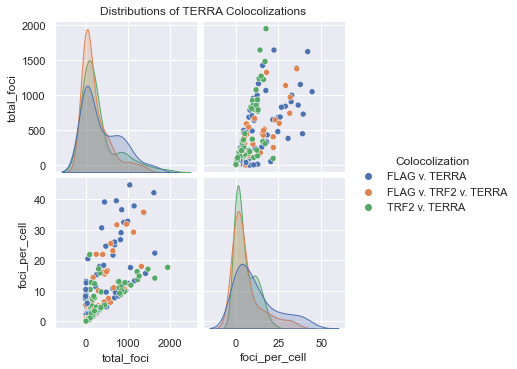

In [71]:
#Seeing the distribution of all the TERRA colocolizations
sns.pairplot(telo_df, hue="Colocolization", aspect=1, #palette="dark"
            )
plt.title("Distributions of TERRA Colocolizations", x=0, y=2.05)
#plt.legend(bbox_to_anchor=(2.01, 5),
           #borderaxespad=0)

Text(0, 2.05, 'Distributions of TERRA Colocolizations')

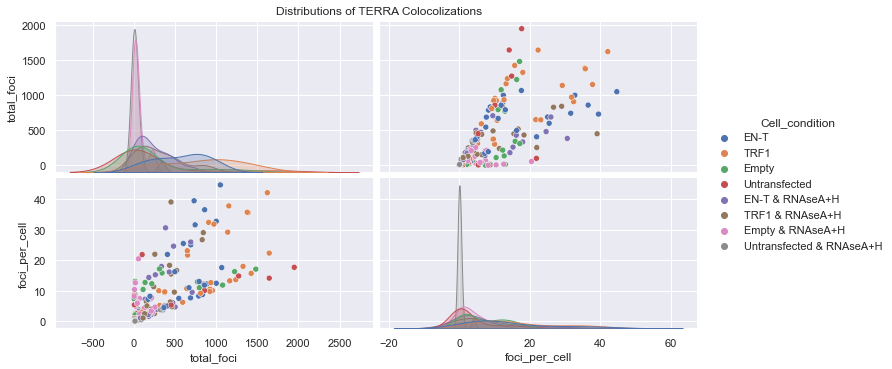

In [72]:
#Seeing if the cell transfection influences TERRA colocoliztion
sns.pairplot(telo_df, hue="Cell_condition", aspect=2, #palette="dark"
            )
plt.title('Distributions of TERRA Colocolizations', x=0, y=2.05)

# TERRA locolization to Telomeric DSBs accumulated in the G2 phase of the cell cycle
  - Same experiment but assesed based on cells transfected with:
      - "G1 (stained  ONLY  with DAPI), in S phase (stained with DAPI+EdU) and G2 ( cells stained with green FUCCI and DAPI) and then compared this to the number of TERRA foci in untransfected control."
      - "To measure the colocalization of FLAG and TERRA  RNA FISH and Immunostaining to label FLAG in positively transfected cells and compare it to untransfected population."
      - to test wheather  this system allowed the formation of telomeric DSBs, cells were  fixed and immunostained to detect
        - a.FLAG  ( to label the positvely transfected cells).
        - b. yH2AX ( DSBs marker)
        - c. Edu ( S phase marker) FUCCI marker (G2 marker). 
        - The fixed cells were also stained with G-rich labeld PNA probe  to detect Telomeres (C-rich strands).

## Bar Plots

Text(0.5, 1.0, 'Percent of Cells per Phase')

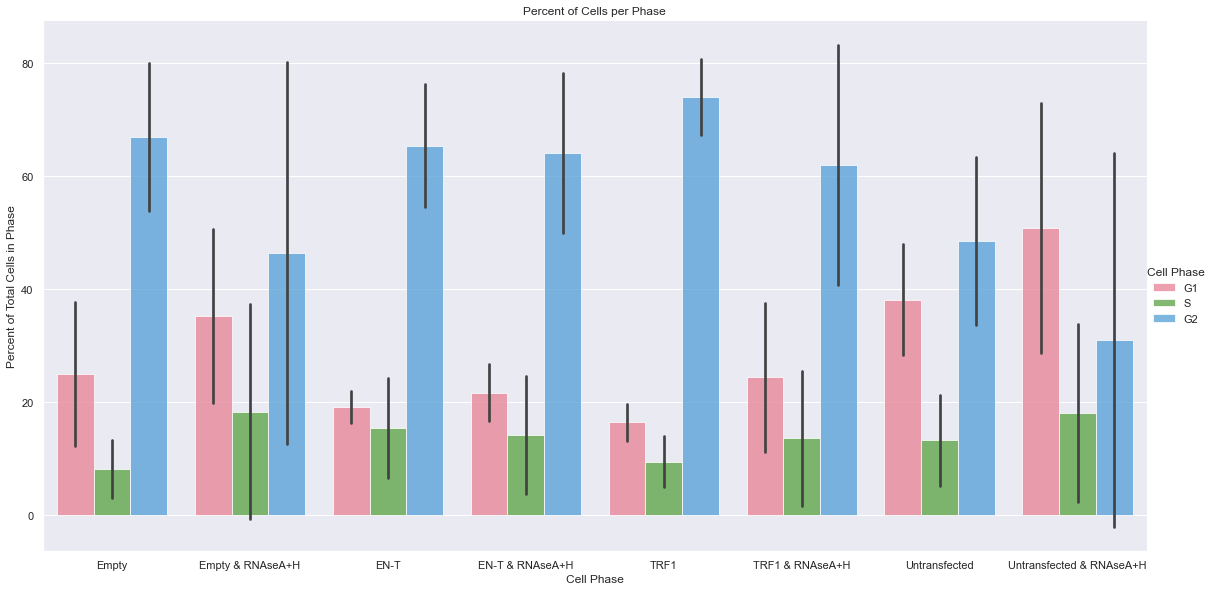

In [85]:
# Catagorical bar plot for percent of cells per phase
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="Cell_%_In_Phase", hue="Phase",
    ci="sd", palette="husl", alpha=.75, height=8, aspect=2
)

g.despine(left=False)
g.set_axis_labels("Cell Phase", "Percent of Total Cells in Phase")
g.legend.set_title("Cell Phase")
plt.title("Percent of Cells per Phase")

Text(0.5, 1.0, 'Percent of TERRA per Phase')

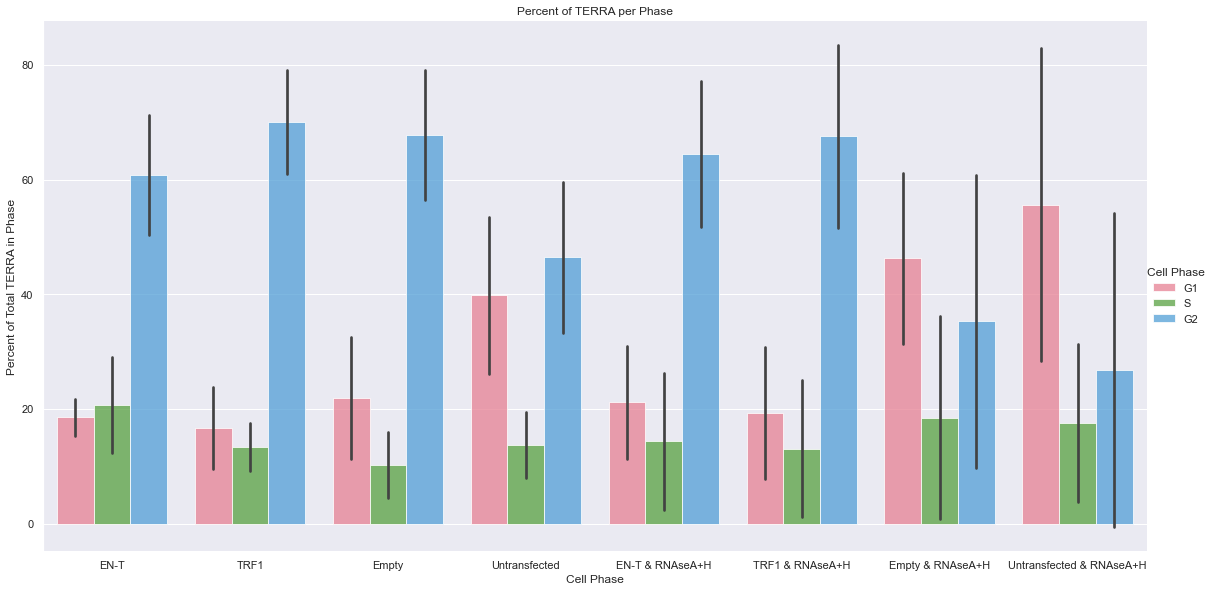

In [88]:
# Catagorical bar plot for percent of TERRA per phase
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA_%_In_Phase", hue="Phase",
    ci="sd", palette="husl", alpha=.75, height=8, aspect=2
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Phase", "Percent of Total TERRA in Phase")
g.legend.set_title("Cell Phase")
plt.title("Percent of TERRA per Phase")

Text(0.5, 1.0, 'Percent of TERRA per Phase')

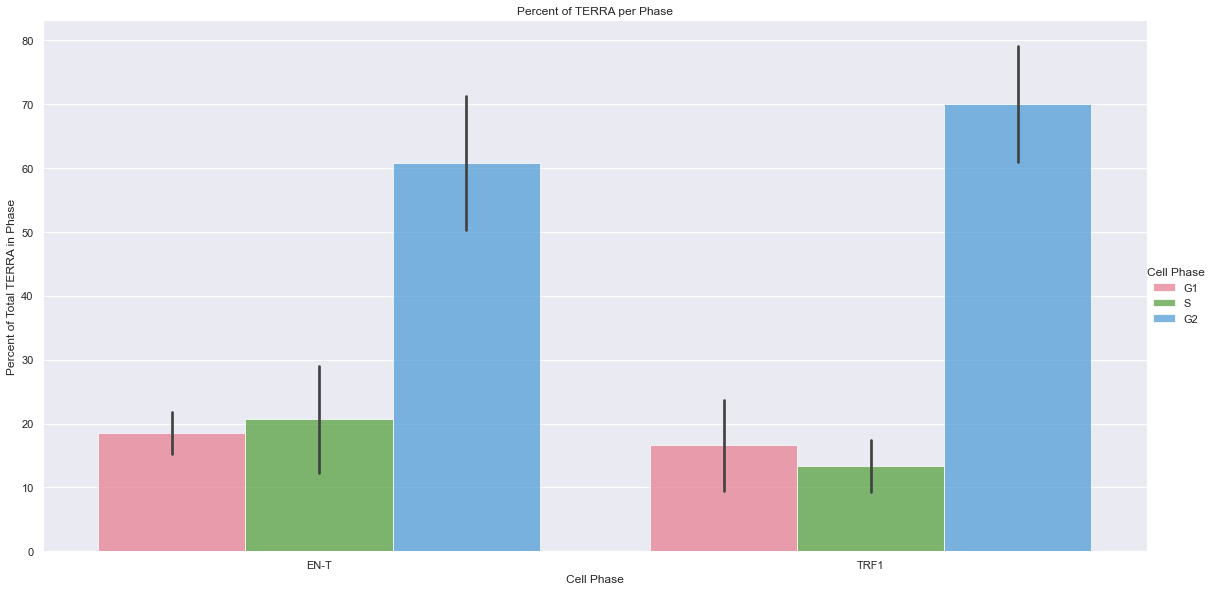

In [75]:
# Show that TERRA accumulates in G2 to Telo DSB's
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA_%_In_Phase", hue="Phase",
    ci="sd", palette="husl", alpha=.75, height=8, aspect=2, order=['EN-T', 'TRF1']
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Phase", "Percent of Total TERRA in Phase")
g.legend.set_title("Cell Phase")
plt.title("Percent of TERRA per Phase")

In [93]:
g2_df.head(33)

,Cell_condition,Phase,TERRA Amount,TERRA_%_In_Phase,Cell_Amount,Cell_%_In_Phase
0,Empty,G1,132.0,10.806386,9.0,11.920530
1,Empty,G1,346.5,23.467660,16.5,24.812030
2,Empty,G1,814.0,41.267427,50.5,49.029126
3,Empty,G1,437.0,20.349243,21.0,21.761658
4,Empty,G1,264.0,13.618777,16.0,17.391304
5,Empty,S,65.0,5.321326,2.0,2.649007
6,Empty,S,245.5,16.627159,10.5,15.789474
7,Empty,S,76.5,3.878327,3.5,3.398058
8,Empty,S,380.5,17.718277,12.0,12.435233
9,Empty,S,152.5,7.866907,6.0,6.521739


In [94]:
#empty [:15]
#Empty &RNAse [16:30]
#EN-T

stats.f_oneway(g2_df['TERRA_%_In_Phase'].iloc[:15],
               g2_df['TERRA_%_In_Phase'].iloc[16:30],
                                 )

F_onewayResult(statistic=0.06386838938100207, pvalue=0.8023972301321219)

Text(0.5, 1.0, 'Percent of TERRA per Phase')

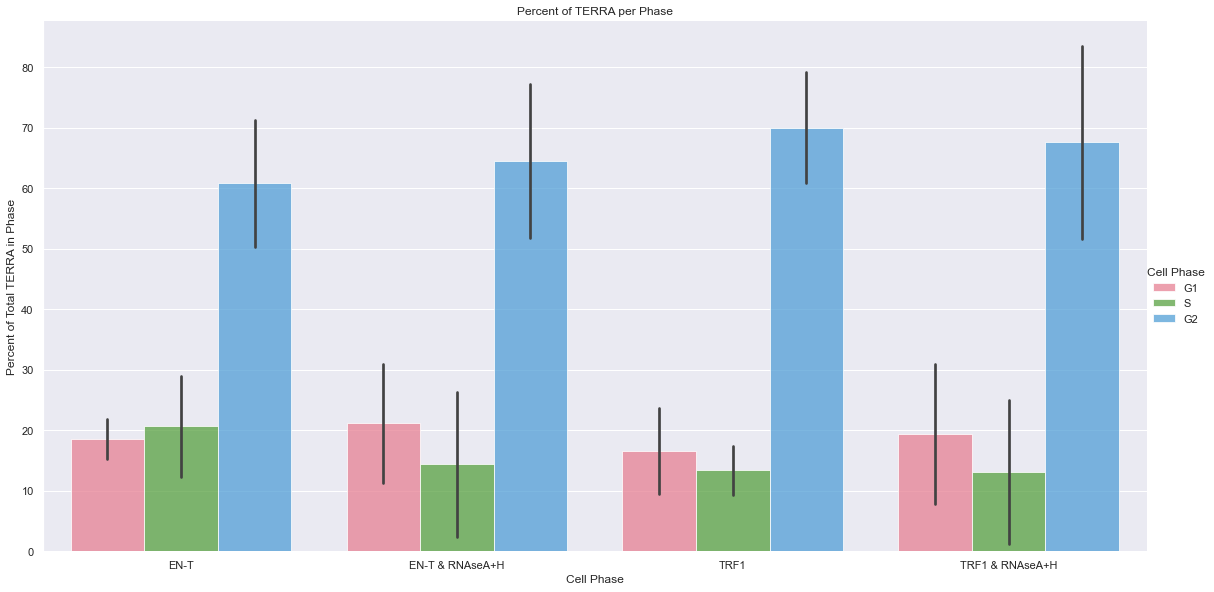

In [76]:
#Show the funky result that RNAse didn't deplete TERRA - consistent across the board
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA_%_In_Phase", hue="Phase",
    ci="sd", palette="husl", alpha=.75, height=8, aspect=2, order=["EN-T","EN-T & RNAseA+H","TRF1","TRF1 & RNAseA+H"]
    
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Phase", "Percent of Total TERRA in Phase")
g.legend.set_title("Cell Phase")
plt.title("Percent of TERRA per Phase")

Text(0.5, 1.0, 'Amount of TERRA per Phase')

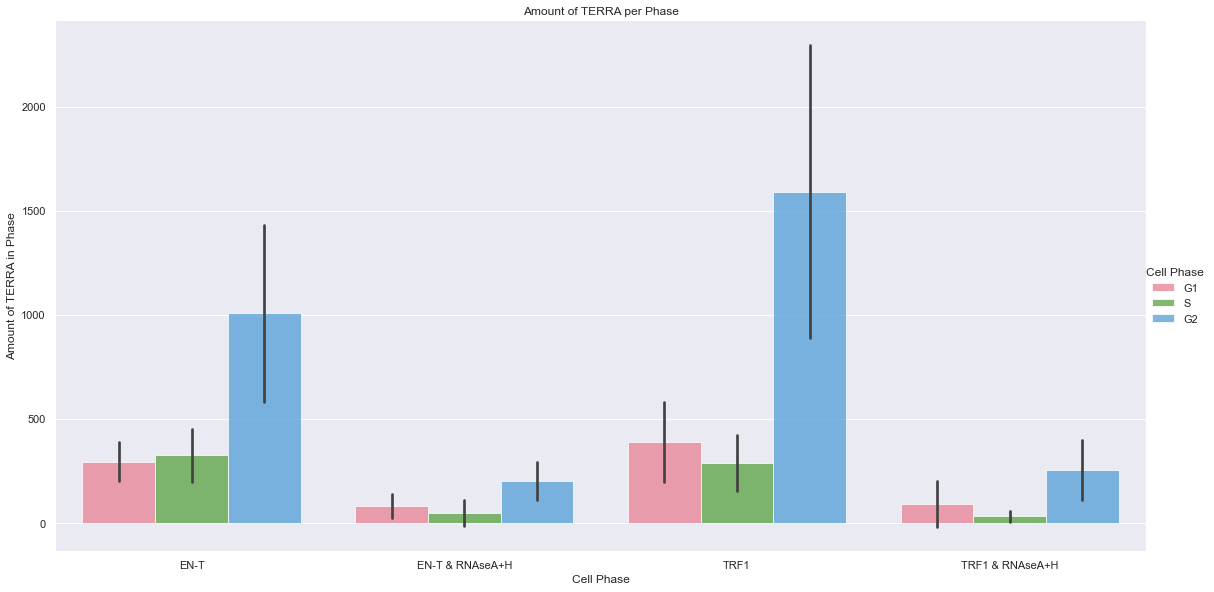

In [102]:
#Show the funky result that RNAse didn't deplete TERRA - consistent across the board
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase",
    ci="sd", palette="husl", alpha=.75, height=8, aspect=2, order=["EN-T","EN-T & RNAseA+H","TRF1","TRF1 & RNAseA+H"]
    
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Phase", "Amount of TERRA in Phase")
g.legend.set_title("Cell Phase")
plt.title("Amount of TERRA per Phase")

Text(0.5, 1.0, 'Percent of TERRA per Phase')

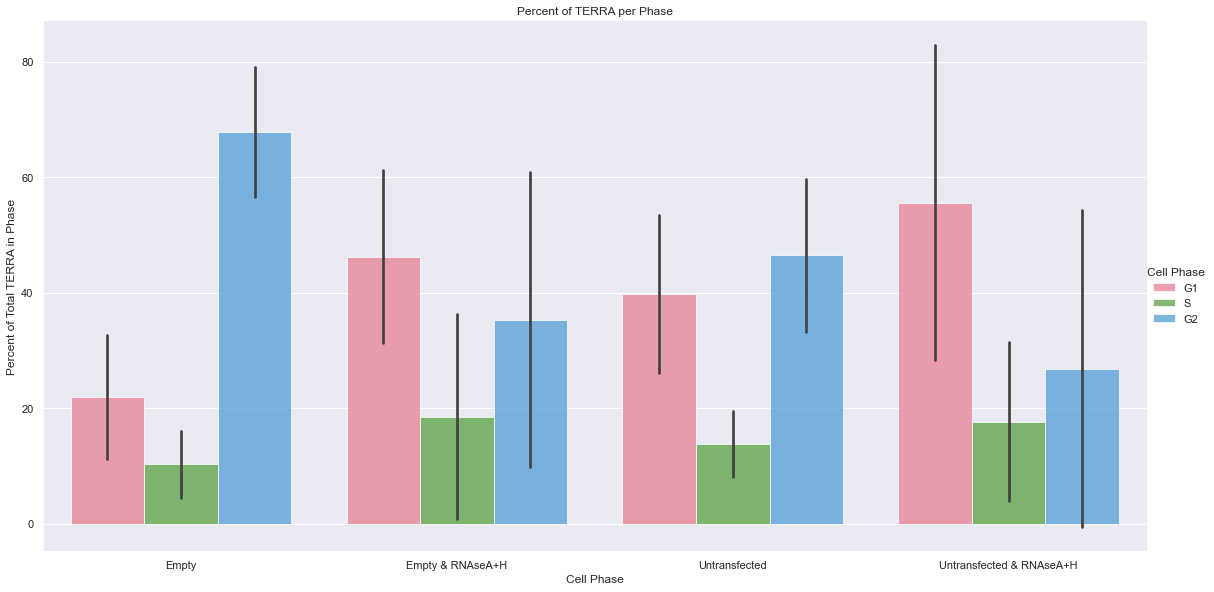

In [98]:
#Show the funky result that TERRA accumulates in G1 in Empty & Untransfected cells +RNAseA+H
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA_%_In_Phase", hue="Phase",
    ci="sd", palette="husl", alpha=.75, height=8, aspect=2, order=["Empty","Empty & RNAseA+H","Untransfected","Untransfected & RNAseA+H"],  
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Phase", "Percent of Total TERRA in Phase")
g.legend.set_title("Cell Phase")
plt.title("Percent of TERRA per Phase")

Text(0.5, 1.0, 'Amount of TERRA per Phase')

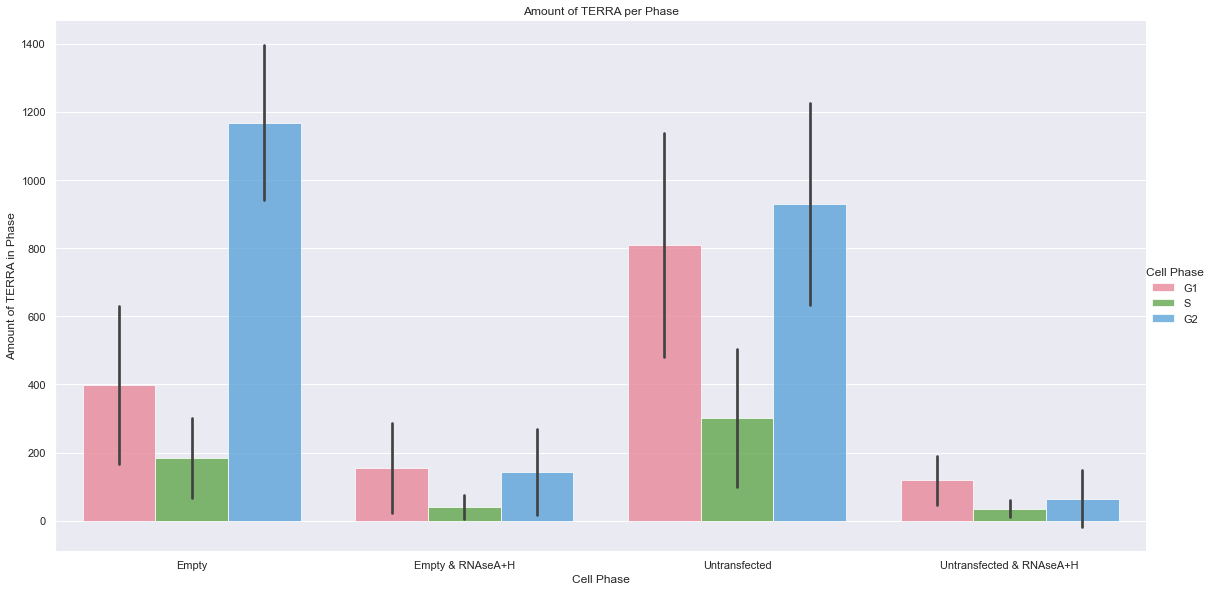

In [103]:
#Show the funky result that TERRA accumulates in G1 in Empty & Untransfected cells +RNAseA+H
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase",
    ci="sd", palette="husl", alpha=.75, height=8, aspect=2, order=["Empty","Empty & RNAseA+H","Untransfected","Untransfected & RNAseA+H"],  
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Phase", "Amount of TERRA in Phase")
g.legend.set_title("Cell Phase")
plt.title("Amount of TERRA per Phase")

## Distributions

Text(-3, 1.25, 'Percent of Cell vs. Percent of TERRA Per Phase')

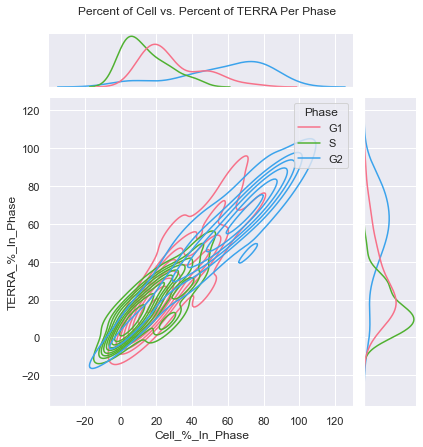

In [78]:
# Show that both the majority percent of cells and percent of TERRA accumulate in G2
g = sns.jointplot(
    data=g2_df,
    x="Cell_%_In_Phase", y="TERRA_%_In_Phase", hue="Phase",
    kind="kde", palette="husl"
)

plt.title('Percent of Cell vs. Percent of TERRA Per Phase', x=-3, y=1.25)

Text(-3, 1.25, 'Percent of Cell vs. Percent of TERRA Depending on Cell Condition')

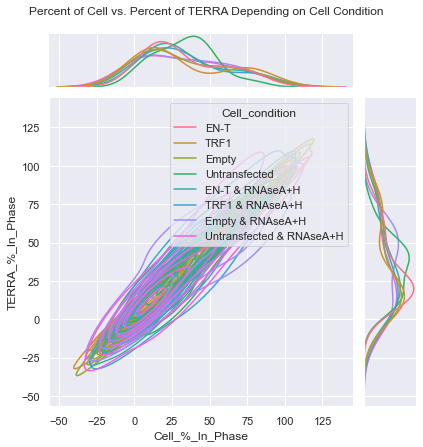

In [79]:
# Show that the accunulation in G2 is independent of the cell condition
g = sns.jointplot(
    data=g2_df,
    x="Cell_%_In_Phase", y="TERRA_%_In_Phase", hue="Cell_condition",
    kind="kde",palette="husl"
)

plt.title('Percent of Cell vs. Percent of TERRA Depending on Cell Condition', x=-3, y=1.25)

Text(-1, 4.15, 'TERRA and Cell Metrics Distributed Based On Cell Phase')

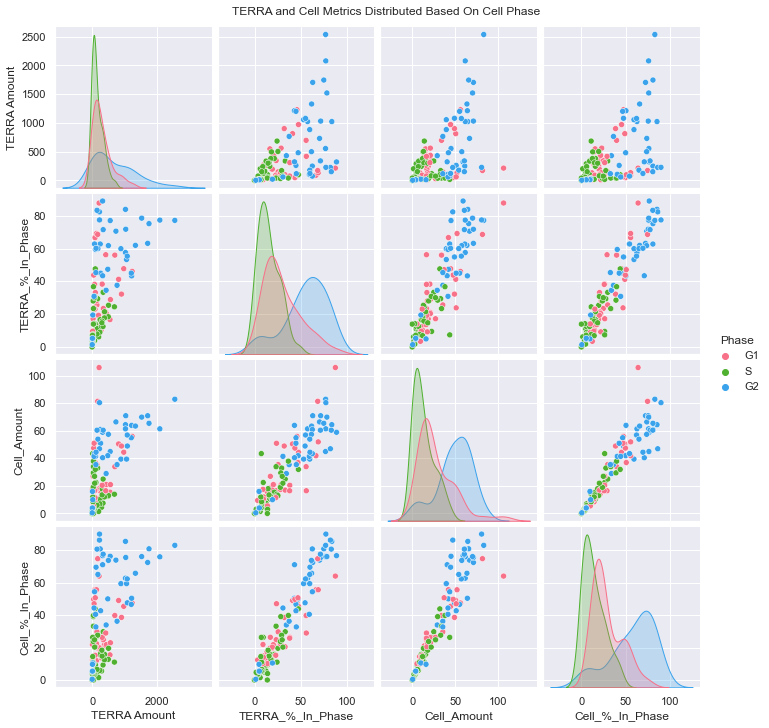

In [80]:
#Seeing the distribution of TERRA and cells through the cell cycle
sns.pairplot(g2_df, hue="Phase", aspect=1, palette="husl")
plt.title('TERRA and Cell Metrics Distributed Based On Cell Phase', x=-1, y=4.15)

Text(-1, 4.15, 'TERRA and Cell Metrics Distributed Based On Cell Condition')

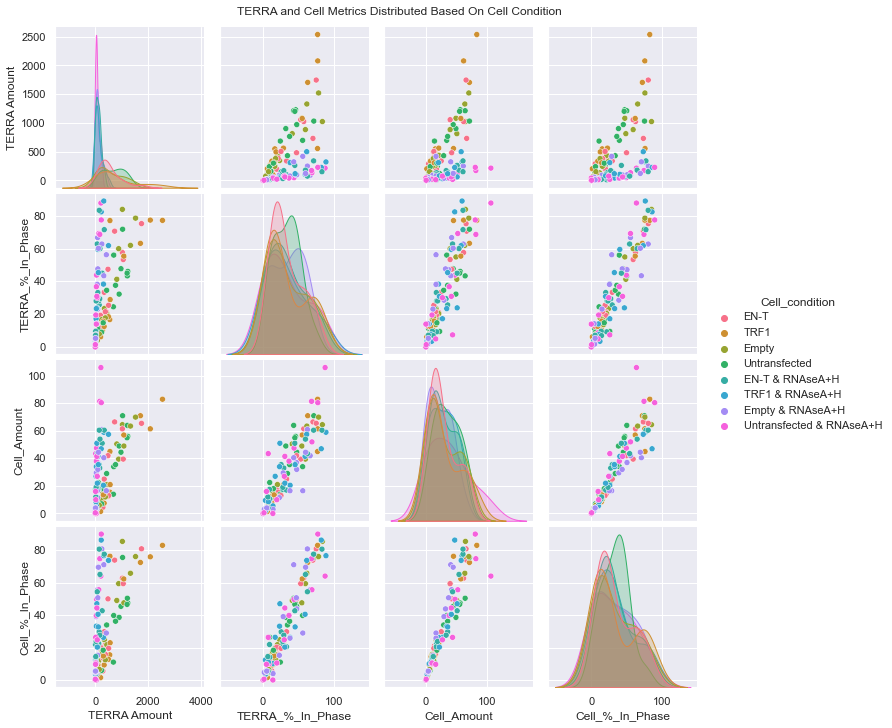

In [81]:
# Seeing if the cell transfection was responsible for the increased TERRA in G2
sns.pairplot(g2_df, hue="Cell_condition", aspect=1, palette="husl")
plt.title('TERRA and Cell Metrics Distributed Based On Cell Condition',x=-1, y=4.15)